# Model Evaluation

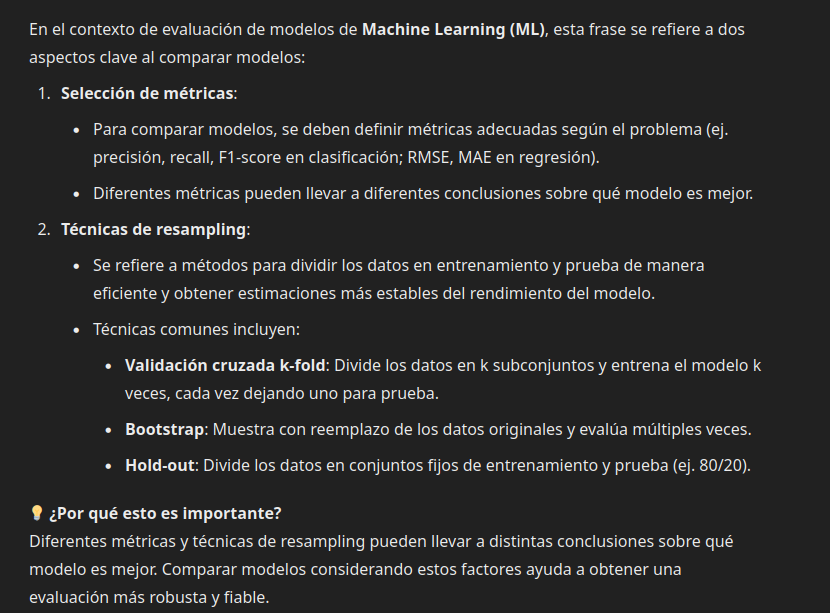

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import pickle
import os
from IPython.display import display
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, 
                             auc, precision_recall_curve)
from sklearn.preprocessing import label_binarize

data_folder = "dataset_matlab"

# Cargar conjuntos de datos
X_train = pd.read_csv(f"{data_folder}/X_train.csv")
y_train = pd.read_csv(f"{data_folder}/y_train.csv").values.ravel()
X_test = pd.read_csv(f"{data_folder}/X_test.csv")
y_test = pd.read_csv(f"{data_folder}/y_test.csv").values.ravel()

model_dir = "models/pump_matlab"

In [2]:
def load_model(model_path):
    with open(model_path, 'rb') as f:
        return pickle.load(f)
    
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    
    # Convertir la matriz a porcentajes (normalizando por filas)
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Normaliza por filas
    
    plt.figure()
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))

    plt.xlabel("Predicciones")
    plt.ylabel("Valores Reales")
    plt.title(title)
    plt.show()

def plot_roc_curves(y_test, y_test_proba, n_classes, class_names):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Calcular curvas ROC y AUC para cada clase
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_test_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Calcular la curva ROC micro-average (micro)
    fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_test_proba.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    
    # Calcular la curva ROC macro-average (macro)
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    
    fpr_macro = all_fpr
    tpr_macro = mean_tpr
    roc_auc_macro = auc(fpr_macro, tpr_macro)
    
    # Calcular la curva ROC weighted-average (weighted)
    weights = np.sum(y_test, axis=0) / np.sum(y_test)
    weighted_tpr = np.zeros_like(all_fpr)
    
    for i in range(n_classes):
        weighted_tpr += weights[i] * np.interp(all_fpr, fpr[i], tpr[i])
    
    fpr_weighted = all_fpr
    tpr_weighted = weighted_tpr
    roc_auc_weighted = auc(fpr_weighted, tpr_weighted)
    
    # Graficar las curvas
    plt.figure()
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')
    
    # Agregar las curvas micro, macro y weighted
    plt.plot(fpr_micro, tpr_micro, label=f'Micro (AUC = {roc_auc_micro:.2f})', linestyle='--')
    plt.plot(fpr_macro, tpr_macro, label=f'Macro (AUC = {roc_auc_macro:.2f})', linestyle='--')
    plt.plot(fpr_weighted, tpr_weighted, label=f'Weighted (AUC = {roc_auc_weighted:.2f})', linestyle='--')
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.legend(loc="lower right")
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curvas ROC Multiclase')
    plt.legend(loc="lower right")
    plt.show()


def plot_metrics(model, X_train, X_test, y_train, y_test, train_output_widget, test_output_widget, cm_widget, roc_widget):
    with train_output_widget:
        train_output_widget.clear_output()
        
        # Predicciones
        y_train_pred = model.predict(X_train)

        # Reporte de clasificación
        print("Train Classification Report:")
        print(classification_report(y_train, y_train_pred))

    with test_output_widget:
        test_output_widget.clear_output()
        
        # Predicciones
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
        
        # Reporte de clasificación
        print("Test Classification Report:")
        print(classification_report(y_test, y_test_pred))

    with roc_widget:
        roc_widget.clear_output()
        # Curvas ROC
        if y_test_proba is not None:
            y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
            n_classes = y_test_bin.shape[1]
            plot_roc_curves(y_test_bin, y_test_proba, n_classes, np.unique(y_test))
        
    with cm_widget:
        cm_widget.clear_output()
        plot_confusion_matrix(y_test, y_test_pred, "Matriz de confusión (test)")


def select_model_ui(models_dir, X_train, X_test, y_train, y_test):
    model_files = [f for f in os.listdir(models_dir) if f.endswith('.pkl')]
    
    model_selector = widgets.Dropdown(
        options=model_files,
        description='Modelo:',
        disabled=False
    )
    
    train_output_widget = widgets.Output()
    test_output_widget = widgets.Output()
    cm_widget = widgets.Output()
    roc_widget = widgets.Output()

    # Ajustar el margen usando layout
    spacer = widgets.Label(' ', layout=widgets.Layout(width='100px'))
    
    def on_model_change(change):
        if change["type"] == "change" and change["name"] == "value":
            model_path = os.path.join(models_dir, change["new"])
            model = load_model(model_path)
            plot_metrics(model, X_train, X_test, y_train, y_test, train_output_widget, test_output_widget, cm_widget, roc_widget)
    
    model_selector.observe(on_model_change, names='value')
    
    display(model_selector, widgets.HBox([train_output_widget, spacer, test_output_widget]), widgets.HBox([cm_widget, roc_widget]))

select_model_ui(model_dir, X_train, X_test, y_train, y_test)


Dropdown(description='Modelo:', options=('AdaBoost.pkl', 'Bagging.pkl', 'Bernoulli Naive Bayes.pkl', 'Decision…

In [7]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np
import seaborn as sns

# Cargar los conjuntos de datos desde archivos CSV
X_train = pd.read_csv("datasets/X_train.csv")
y_train = pd.read_csv("datasets/y_train.csv").values.ravel()
X_test = pd.read_csv("datasets/X_test.csv")
y_test = pd.read_csv("datasets/y_test.csv").values.ravel()

# Modelos de clasificación
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, SGDClassifier, Perceptron, PassiveAggressiveClassifier
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC
from sklearn.ensemble import (
    RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, 
    ExtraTreesClassifier, BaggingClassifier, HistGradientBoostingClassifier
)
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, ComplementNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# Modelos disponibles
model_options = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM (SVC)": SVC(probability=True),
    "SVM (NuSVC)": NuSVC(probability=True),
    "Random Forest": RandomForestClassifier(),
    "Hist Gradient Boosting": HistGradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "Extra Trees": ExtraTreesClassifier(),
    "Bagging": BaggingClassifier(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Quadratic Discriminant Analysis": QuadraticDiscriminantAnalysis(),
    "MLP (Neural Network)": MLPClassifier()
}

# Técnicas de resampling
resampling_options = {
    'Stratified K-Fold': StratifiedKFold(n_splits=5),
    'Bootstrap': 'bootstrap'
}

def get_pipeline(model):
    return make_pipeline(model)

# Función para realizar muestreo bootstrap
def bootstrap_sampling(X, y, n_iterations=15):
    indices = np.random.choice(np.arange(len(X)), size=(n_iterations, len(X)), replace=True)
    return indices

# Función para entrenar y evaluar el modelo
def evaluate_model(model_choice, resampling_choice, output_widget, output_metrics):
    model = get_pipeline(model_options[model_choice])
    resampling = resampling_options[resampling_choice]
    
    # Listas para almacenar las métricas
    precision_bs = []
    recall_bs = []
    f1_bs = []
    auc_roc_bs = []
    
    # Validación cruzada usando resampling
    if resampling_choice == 'Stratified K-Fold':
        for train_idx, test_idx in resampling.split(X_train, y_train):
            model.fit(X_train.iloc[train_idx], y_train[train_idx])
            y_pred = model.predict(X_train.iloc[test_idx])
            
            # Calcular las métricas
            precision_bs.append(precision_score(y_train[test_idx], y_pred, average='weighted', zero_division=0))
            recall_bs.append(recall_score(y_train[test_idx], y_pred, average='weighted'))
            f1_bs.append(f1_score(y_train[test_idx], y_pred, average='weighted'))
            auc_roc_bs.append(roc_auc_score(y_train[test_idx], model.predict_proba(X_train.iloc[test_idx]), multi_class='ovr', average='weighted'))
        
        # Promediar las métricas
        metrics = {
            'Precision': np.mean(precision_bs),
            'Recall': np.mean(recall_bs),
            'F1 Score': np.mean(f1_bs),
            'AUC-ROC': np.mean(auc_roc_bs)
        }
        
        # Imprimir las métricas de validación cruzada
        output_metrics.clear_output()
        with output_metrics:
            print("\nCross-Validation Metrics:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")
    
    elif resampling_choice == 'Bootstrap':
        # Generar indices bootstrap
        bootstrap_indices = bootstrap_sampling(X_train, y_train)
        for indices in bootstrap_indices:
            X_resampled = X_train.iloc[indices]
            y_resampled = y_train[indices]
            
            model.fit(X_resampled, y_resampled)
            y_pred = model.predict(X_resampled)
            
            # Calcular las métricas
            precision_bs.append(precision_score(y_resampled, y_pred, average='weighted', zero_division=0))
            recall_bs.append(recall_score(y_resampled, y_pred, average='weighted'))
            f1_bs.append(f1_score(y_resampled, y_pred, average='weighted'))
            auc_roc_bs.append(roc_auc_score(y_resampled, model.predict_proba(X_resampled), multi_class='ovr', average='weighted'))
        
        # Promediar las métricas
        metrics = {
            'Precision': np.mean(precision_bs),
            'Recall': np.mean(recall_bs),
            'F1 Score': np.mean(f1_bs),
            'AUC-ROC': np.mean(auc_roc_bs)
        }
        
        # Imprimir las métricas de bootstrap
        output_metrics.clear_output()
        with output_metrics:
            print("\nBootstrap Metrics:")
            for metric, value in metrics.items():
                print(f"{metric}: {value:.4f}")
    
    # Entrenar en todo el conjunto de entrenamiento y evaluar en el conjunto de prueba
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calcular y mostrar las métricas para el conjunto de prueba
    test_metrics = {
        'Precision': precision_score(y_test, y_pred, average='weighted', zero_division=0),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1 Score': f1_score(y_test, y_pred, average='weighted'),
        'AUC-ROC': roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr', average='weighted')
    }
    
    with output_metrics:
        print("\nTest Metrics:")
        for metric, value in test_metrics.items():
            print(f"{metric}: {value:.4f}")
    
    # Mostrar la matriz de confusión en el widget Output
    with output_widget:
        output_widget.clear_output()
        plot_confusion_matrix(y_test, y_pred, "Confusion Matrix")


def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    
    # Convertir la matriz a porcentajes (normalizando por filas)
    cm_percent = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100  # Normaliza por filas
    
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm_percent, annot=True, fmt=".2f", cmap="Blues", xticklabels=set(y_test), yticklabels=set(y_test))

    plt.xlabel("Predicciones")
    plt.ylabel("Valores Reales")
    plt.title(title)
    plt.show()

# Función que se ejecuta al presionar el botón
def on_button_click(b):
    model_choice = model_widget.value
    resampling_choice = resampling_widget.value
    evaluate_model(model_choice, resampling_choice, output_widget, output_metrics)

# Widgets para la interfaz
model_widget = widgets.Dropdown(options=model_options.keys(), description='Model:')
resampling_widget = widgets.Dropdown(options=resampling_options.keys(), description='Resampling:')

# Botón para ejecutar el proceso
run_button = widgets.Button(description="Run Evaluation")
run_button.on_click(on_button_click)

# Crear el Output widget para mostrar la matriz de confusión
output_widget = widgets.Output()

# Crear el Output widget para mostrar las métricas
output_metrics = widgets.Output()

# Organizar los widgets y outputs en un HBox
inputs_box = widgets.VBox([model_widget, resampling_widget, run_button])
outputs_box = widgets.HBox([output_metrics, output_widget])

# Mostrar los widgets y outputs en un VBox
display(widgets.HBox([inputs_box, outputs_box]))
